Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [53]:
import numpy as np
import requests

API_KEY = 'ei_xxx'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/81068/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/81068/training/5/y')


Store the data in a temporary file, and load it back through Numpy.

In [54]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [55]:
X.shape, Y.shape

((3918, 11), (3918,))

In [56]:
Y

array([6, 4, 4, ..., 5, 5, 4], dtype=int32)

In [57]:
set(Y)

{1, 2, 3, 4, 5, 6, 7}

Define our labels and split the data up in a test and training set:

In [58]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "3", "4", "5", "6", "7", "8", "9" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Train the model:

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(classes, name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='mse',
              metrics=['mae'], 
              optimizer=opt)

history = model.fit(train_dataset, 
                    epochs=100, 
                    validation_data=validation_dataset, 
                    verbose=2, 
                    callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/100
98/98 - 1s - loss: 0.1150 - mae: 0.2069 - val_loss: 0.1012 - val_mae: 0.2031
Epoch 2/100
98/98 - 1s - loss: 0.0971 - mae: 0.2000 - val_loss: 0.0942 - val_mae: 0.1954
Epoch 3/100
98/98 - 1s - loss: 0.0937 - mae: 0.1934 - val_loss: 0.0916 - val_mae: 0.1909
Epoch 4/100
98/98 - 1s - loss: 0.0918 - mae: 0.1892 - val_loss: 0.0897 - val_mae: 0.1875
Epoch 5/100
98/98 - 1s - loss: 0.0903 - mae: 0.1857 - val_loss: 0.0884 - val_mae: 0.1847
Epoch 6/100
98/98 - 1s - loss: 0.0892 - mae: 0.1834 - val_loss: 0.0877 - val_mae: 0.1828
Epoch 7/100
98/98 - 1s - loss: 0.0885 - mae: 0.1820 - val_loss: 0.0872 - val_mae: 0.1817
Epoch 8/100
98/98 - 1s - loss: 0.0879 - mae: 0.1811 - val_loss: 0.0869 - val_mae: 0.1814
Epoch 9/100
98/98 - 1s - loss: 0.0874 - mae: 0.1804 - val_loss: 0.0867 - val_mae: 0.1805
Epoch 10/100
98/98 - 1s - loss: 0.0870 - mae: 0.1797 - val_loss: 0.0865 - val_mae: 0.1799
Epoch 11/100
98/98 - 1s - loss: 0.0867 - mae: 0.1791 - val_loss: 0.0863 - val_mae: 0.1793
Epoch 12/100
98/98 

98/98 - 1s - loss: 0.0814 - mae: 0.1677 - val_loss: 0.0837 - val_mae: 0.1699
Epoch 93/100
98/98 - 1s - loss: 0.0814 - mae: 0.1677 - val_loss: 0.0837 - val_mae: 0.1698
Epoch 94/100
98/98 - 1s - loss: 0.0814 - mae: 0.1676 - val_loss: 0.0837 - val_mae: 0.1698
Epoch 95/100
98/98 - 1s - loss: 0.0814 - mae: 0.1676 - val_loss: 0.0837 - val_mae: 0.1698
Epoch 96/100
98/98 - 1s - loss: 0.0814 - mae: 0.1675 - val_loss: 0.0838 - val_mae: 0.1698
Epoch 97/100
98/98 - 1s - loss: 0.0814 - mae: 0.1675 - val_loss: 0.0837 - val_mae: 0.1698
Epoch 98/100
98/98 - 1s - loss: 0.0813 - mae: 0.1674 - val_loss: 0.0838 - val_mae: 0.1697
Epoch 99/100
98/98 - 1s - loss: 0.0813 - mae: 0.1673 - val_loss: 0.0837 - val_mae: 0.1697
Epoch 100/100
98/98 - 1s - loss: 0.0813 - mae: 0.1673 - val_loss: 0.0837 - val_mae: 0.1696


In [60]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

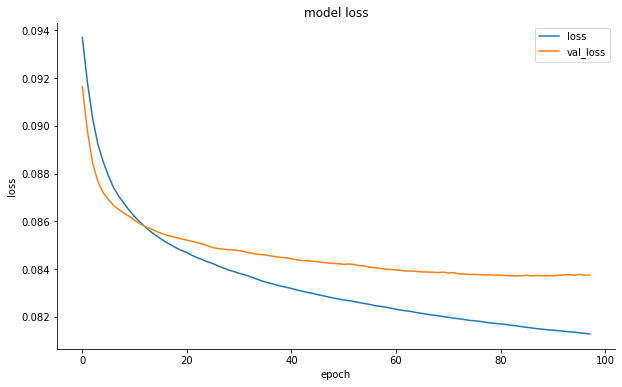

In [61]:
plt.plot(history.history['loss'][2:], label='loss')
plt.plot(history.history['val_loss'][2:], label='val_loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

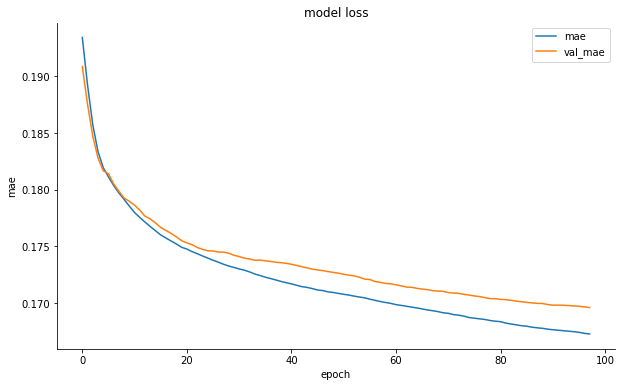

In [62]:
plt.plot(history.history['mae'][2:], label='mae')
plt.plot(history.history['val_mae'][2:], label='val_mae')
plt.title('model loss')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

## Testing

In [29]:
tst = np.array([0.3000, 0.1716, 0.1446, 0.0169, 0.0890, 0.9443, 0.8647, 0.1429, 0.7364, 0.3605, 0.2581])
tst = np.reshape(tst, (1, X_train.shape[1]))
model.predict(tst)
p = model.predict(tst)[0]
p[0]*3 + p[1]*4 + p[2]*5 + p[3]*6 + p[4]*7 + p[5]*8

5.09334905911237

In [30]:
tst = np.array([0.2500, 0.1176, 0.1446, 0.0123, 0.0712, 0.4321, 0.5248, 0.0640, 0.7909, 0.3953, 0.6935])
tst = np.reshape(tst, (1, X_train.shape[1]))
model.predict(tst)
p = model.predict(tst)[0]
p[0]*3 + p[1]*4 + p[2]*5 + p[3]*6 + p[4]*7 + p[5]*8

6.243083450943232

In [ ]:
# Save the model to disk
model.save('saved_model')